Dataset ini terorganisir dalam 3 folder (train, test, val) dan berisi subfolder untuk setiap kategori gambar (Pneumonia/Normal). Terdapat 5.863 gambar sinar-X (JPEG) dan 2 kategori (Pneumonia/Normal). Gambar sinar-X dada (anterior-posterior) dipilih dari kohort retrospektif pasien anak-anak berusia satu hingga lima tahun dari Guangzhou Women and Children’s Medical Center, Guangzhou.

Notebook ini ditulis oleh: Ghefira Nur Fatimah Widyasari

Import kaggle.json dan dataset dari kaggle

In [9]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

# Move the uploaded file to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [10]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!ls ~/.kaggle

In [11]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:14<00:00, 218MB/s]
100% 2.29G/2.29G [00:14<00:00, 168MB/s]


Import library

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [14]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [16]:
!unzip chest-xray-pneumonia.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  in

Membagi data dan disimpan dalam train_data, test_data, dan val_data

In [19]:
train_path = "chest_xray/train"
test_path = "chest_xray/test"
val_path = "chest_xray/val"

train_data = get_training_data(train_path)
test_data = get_training_data(test_path)
val_data = get_training_data(val_path)

<ipython-input-14-b2613b36a4a4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [28]:
num_train_data = len(train_data)
num_test_data = len(test_data)
num_val_data = len(val_data)

# Show the number of data
print(f"Jumlah data di set pelatihan (train): {num_train_data} data")
print(f"Jumlah data di set pengujian (test): {num_test_data} data")
print(f"Jumlah data di set validasi (val): {num_val_data} data")

Jumlah data di set pelatihan (train): 5216 data
Jumlah data di set pengujian (test): 624 data
Jumlah data di set validasi (val): 16 data


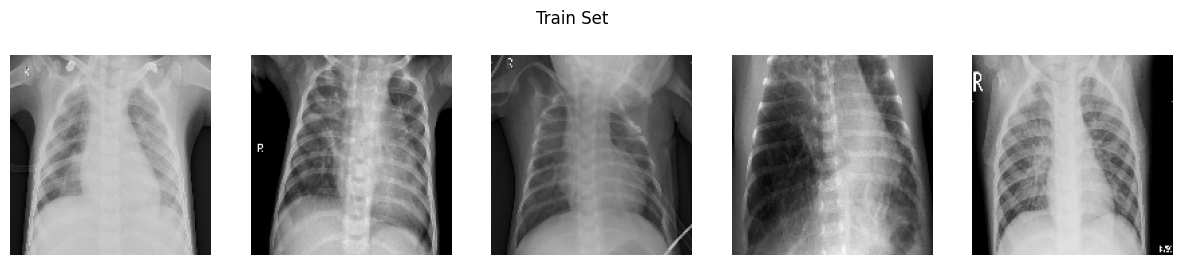

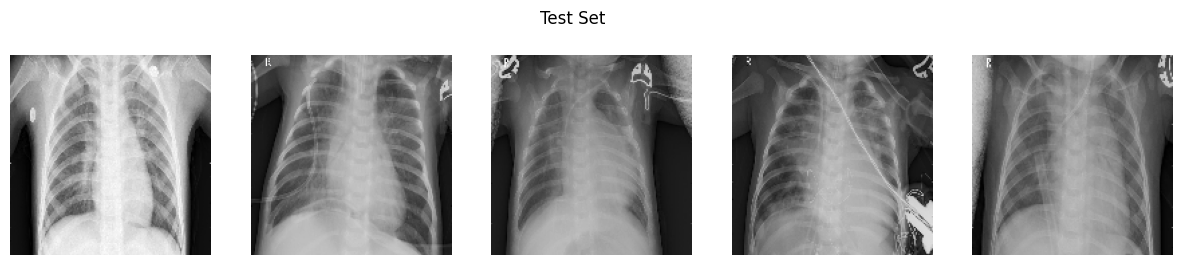

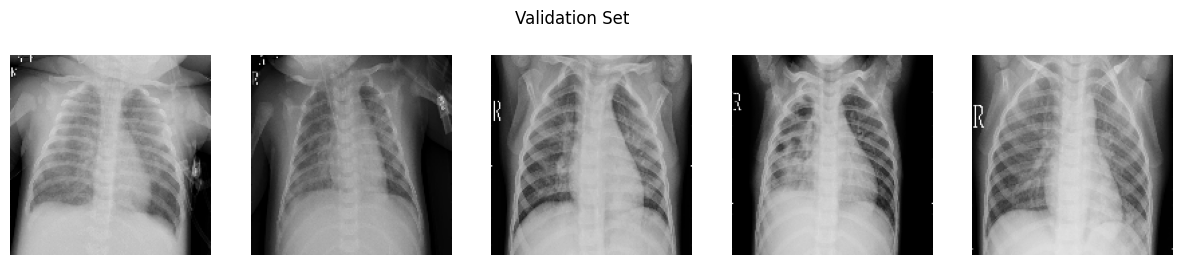

In [20]:
import matplotlib.pyplot as plt

# Function to display images from the dataset
def display_images(data, label):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(label)
    for i in range(5):
        axs[i].imshow(data[i][0], cmap='gray')
        axs[i].axis('off')
    plt.show()

# Display sample images from each set
display_images(train_data, 'Train Set')
display_images(test_data, 'Test Set')
display_images(val_data, 'Validation Set')

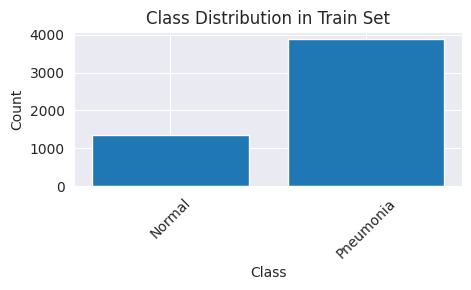

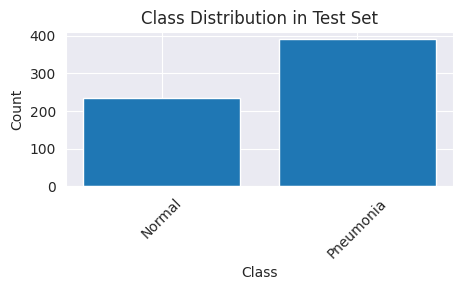

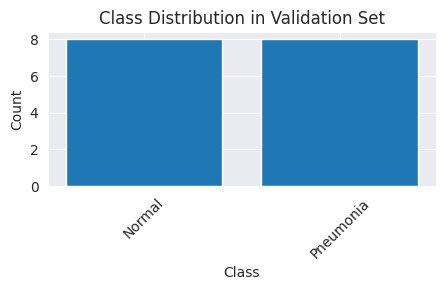

In [33]:
import matplotlib.pyplot as plt
from collections import Counter


# Function to get class labels
def get_class_label(class_num):
    return "Pneumonia" if class_num == 0 else "Normal"

# Function to create class distribution bar diagrams
def plot_class_distribution(data, set_name):
    labels = [get_class_label(item[1]) for item in data]
    plt.figure(figsize=(5, 2))
    plt.title(f"Class Distribution in {set_name} Set")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.bar(*zip(*sorted(Counter(labels).items())))
    plt.show()

# Create a class distribution bar diagram for each set
plot_class_distribution(train_data, "Train")
plot_class_distribution(test_data, "Test")
plot_class_distribution(val_data, "Validation")

<ipython-input-25-2de852c7d05e>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(class_labels, palette=color_palette)


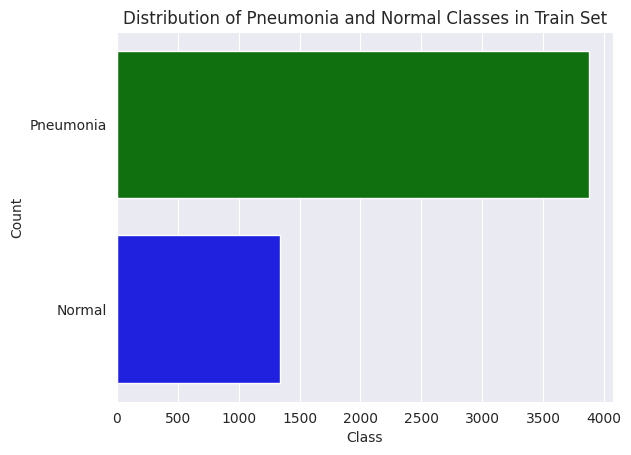

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk mendapatkan label kelas
def get_class_label(class_num):
    return "Pneumonia" if class_num == 0 else "Normal"

# Mendapatkan label kelas untuk setiap data dalam train_data
class_labels = [get_class_label(i[1]) for i in train_data]

# Menentukan palet warna
color_palette = {'Pneumonia': 'green', 'Normal': 'blue'}

# Plot count dengan warna yang diubah
sns.set_style('darkgrid')
sns.countplot(class_labels, palette=color_palette)

# Menambahkan judul dan label sumbu
plt.title('Distribution of Pneumonia and Normal Classes in Train Set')
plt.xlabel('Class')
plt.ylabel('Count')

# Menampilkan plot
plt.show()

Datanya tampaknya tidak seimbang. Untuk menambah jumlah contoh pelatihan, kami akan menggunakan augmentasi data

Text(0.5, 1.0, 'NORMAL')

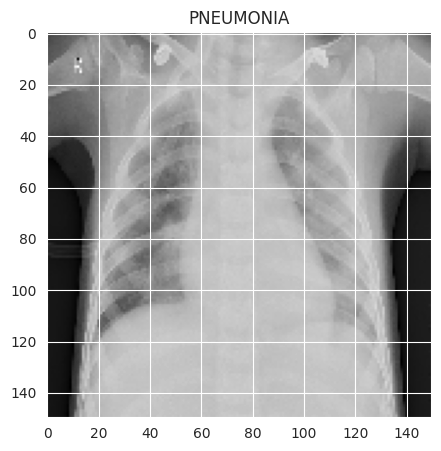

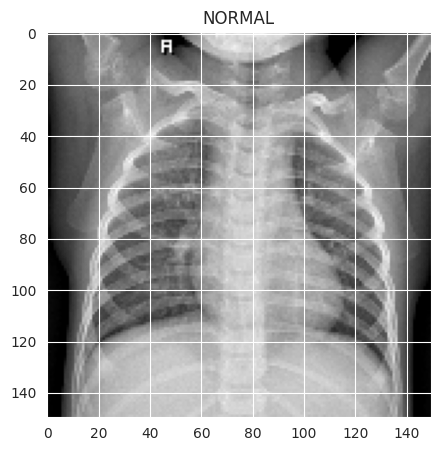

In [27]:
plt.figure(figsize = (5,5))
plt.imshow(train_data[0][0], cmap='gray')
plt.title(labels[train_data[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train_data[-1][0], cmap='gray')
plt.title(labels[train_data[-1][1]])

In [35]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_data:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_data:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val_data:
    x_val.append(feature)
    y_val.append(label)

In [36]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [37]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [38]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [39]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [40]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [50]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 14s 83ms/step - loss: 0.0828 - accuracy: 0.9695 - val_loss: 0.9254 - val_accuracy: 0.7500 - lr: 1.0000e-06
Epoch 2/12
163/163 [==============================] - 13s 81ms/step - loss: 0.0879 - accuracy: 0.9701 - val_loss: 0.6850 - val_accuracy: 0.7500 - lr: 1.0000e-06
Epoch 3/12
163/163 [==============================] - 13s 82ms/step - loss: 0.0834 - accuracy: 0.9718 - val_loss: 0.7209 - val_accuracy: 0.6250 - lr: 1.0000e-06
Epoch 4/12
163/163 [==============================] - 15s 92ms/step - loss: 0.0836 - accuracy: 0.9714 - val_loss: 0.7172 - val_accuracy: 0.6250 - lr: 1.0000e-06
Epoch 5/12
163/163 [==============================] - 13s 82ms/step - loss: 0.0803 - accuracy: 0.9688 - val_loss: 0.7771 - val_accuracy: 0.5625 - lr: 1.0000e-06
Epoch 6/12
163/163 [==============================] - 14s 88ms/step - loss: 0.0875 - accuracy: 0.9678 - val_loss: 0.9851 - val_accuracy: 0.5625 - lr: 1.0000e-06
Epoch 7/12
163/163 [==============

In [51]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 14ms/step - loss: 0.2478 - accuracy: 0.9103
Loss of the model is -  0.2477722465991974
20/20 [==============================] - 0s 13ms/step - loss: 0.2478 - accuracy: 0.9103
Accuracy of the model is -  91.02563858032227 %


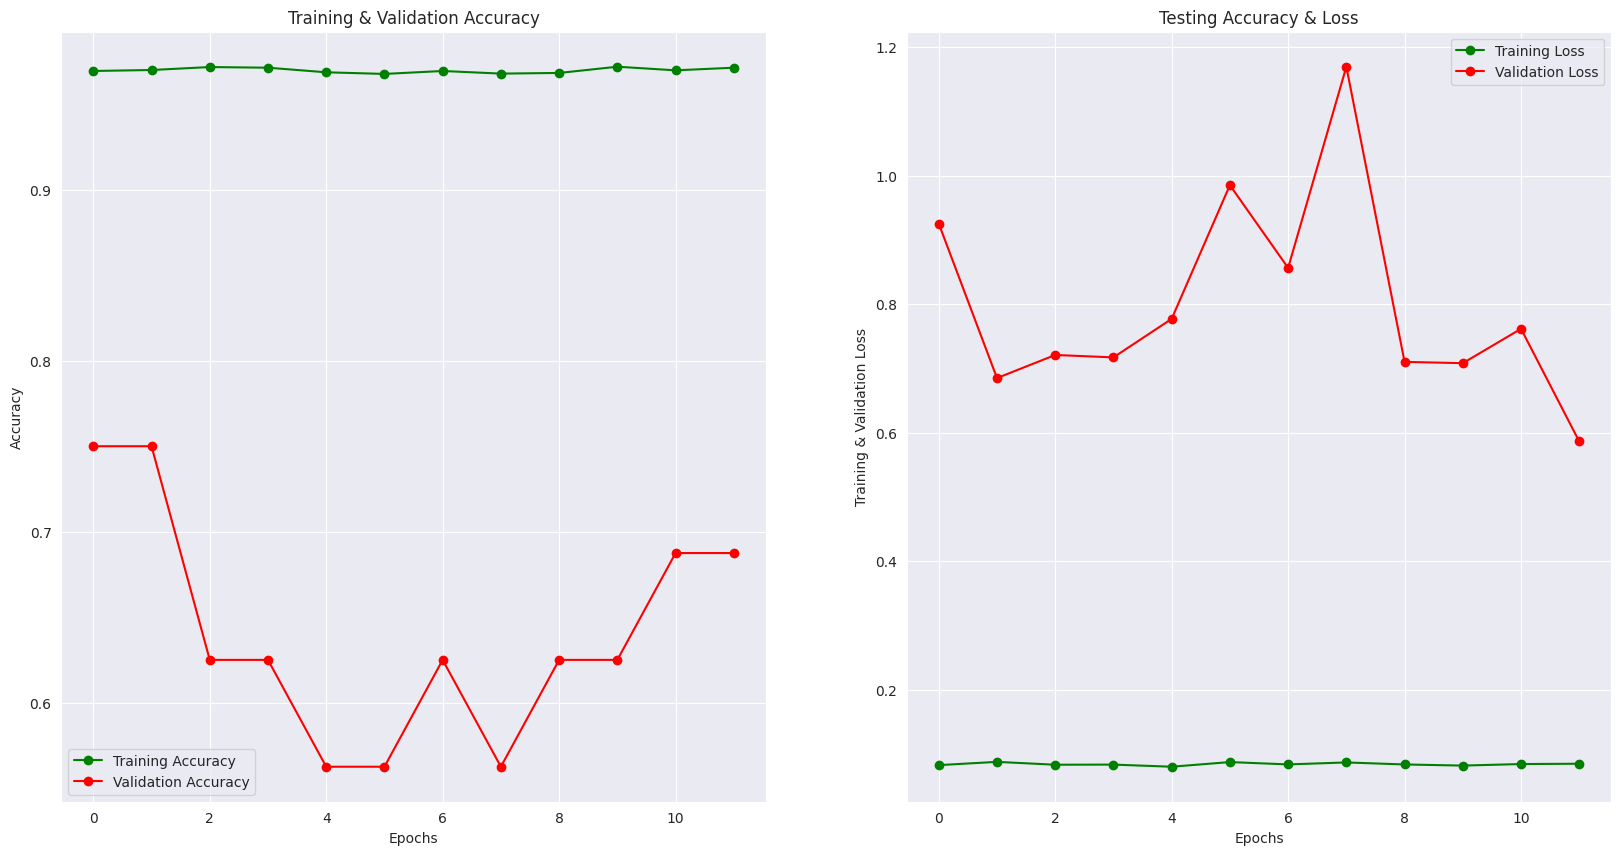

In [54]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [61]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes[:15]

20/20 [==============================] - 0s 11ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [63]:
predictions_binary = np.round(predictions)
print(classification_report(y_test, predictions_binary, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.94      0.93       390
   Normal (Class 1)       0.89      0.87      0.88       234

           accuracy                           0.91       624
          macro avg       0.91      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624



Precision: Precision mengukur seberapa banyak dari kelas yang diprediksi sebagai positif benar-benar positif. Untuk kelas "Pneumonia," precision adalah 0.92, yang berarti 92% dari kasus yang diprediksi sebagai "Pneumonia" adalah benar-benar "Pneumonia." Untuk kelas "Normal," precision adalah 0.89.

Recall: Recall mengukur seberapa banyak dari keseluruhan kelas yang benar-benar positif berhasil diprediksi oleh model. Untuk kelas "Pneumonia," recall adalah 0.94, yang berarti model dapat mengidentifikasi 94% dari kasus sebenarnya "Pneumonia." Untuk kelas "Normal," recall adalah 0.87.

F1-Score: F1-score adalah nilai rata-rata harmonik dari precision dan recall. Nilai F1-score yang baik menunjukkan keseimbangan antara precision dan recall. Untuk kelas "Pneumonia," F1-score adalah 0.93, dan untuk kelas "Normal," F1-score adalah 0.88.

Accuracy: Accuracy mengukur seberapa akurat model dalam memprediksi keseluruhan dataset. Dalam hal ini, akurasi adalah 0.91 atau 91%.

Macro Avg dan Weighted Avg: Macro avg adalah rata-rata dari metrik untuk setiap kelas tanpa mempertimbangkan ketidakseimbangan kelas. Weighted avg memberikan bobot berdasarkan jumlah sampel dalam setiap kelas.

Secara keseluruhan, dengan akurasi sekitar 91% dan hasil evaluasi yang baik untuk precision, recall, dan F1-score

In [65]:
predictions_binary = np.round(predictions)
cm = confusion_matrix(y_test, predictions_binary)
print(cm)

[[365  25]
 [ 31 203]]


In [66]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

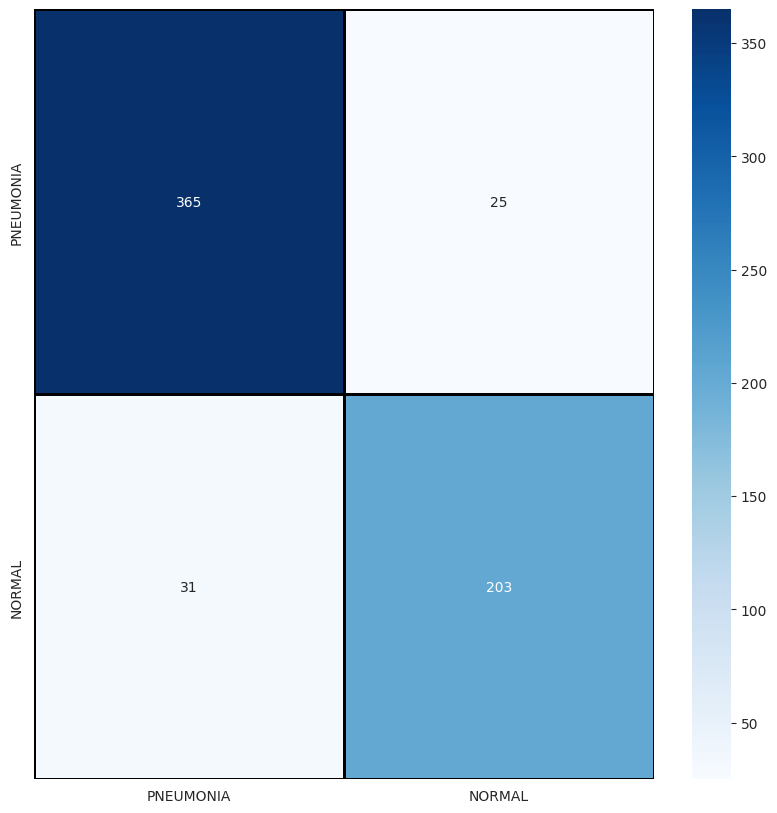

In [67]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [68]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [78]:
# Save the model
model.save("PneumoniaDetection_CNN.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
